In [32]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import json
import gzip
import itertools

from utils import read_json_gz

In [30]:
# Load steamspy details
with gzip.open("allgamesdetails.json.gz", "rt") as f:
    df = pd.read_json(f, orient="index").head(n=1000)
df

,appid,name,developer,publisher,score_rank,positive,negative,userscore,owners,average_forever,average_2weeks,median_forever,median_2weeks,price,initialprice,discount,ccu,languages,genre,tags
570,570,Dota 2,Valve,Valve,,1820456,402016,0,"200,000,000 .. 500,000,000",0,0,0,0,0.0,0.0,0.0,695781,"English, Bulgarian, Czech, Danish, Dutch, Finn...","Action, Strategy, Free to Play","{'Free to Play': 59515, 'MOBA': 19946, 'Multip..."
730,730,Counter-Strike: Global Offensive,Valve,Valve,,6993686,1020377,0,"100,000,000 .. 200,000,000",0,0,0,0,0.0,0.0,0.0,1303120,"English, Czech, Danish, Dutch, Finnish, French...","Action, Free to Play","{'FPS': 90011, 'Shooter': 64730, 'Multiplayer'..."
578080,578080,PUBG: BATTLEGROUNDS,"KRAFTON, Inc.","KRAFTON, Inc.",,1368305,977707,0,"50,000,000 .. 100,000,000",0,0,0,0,0.0,0.0,0.0,604200,"English, Korean, Simplified Chinese, French, G...","Action, Adventure, Massively Multiplayer, Free...","{'Survival': 14594, 'Shooter': 12459, 'Battle ..."
1623730,1623730,Palworld,Pocketpair,Pocketpair,,276200,18105,0,"50,000,000 .. 100,000,000",0,0,0,0,2999.0,2999.0,0.0,49022,"English, Simplified Chinese, Traditional Chine...","Action, Adventure, Indie, RPG, Early Access","{'Multiplayer': 984, 'Open World': 972, 'Survi..."
1063730,1063730,New World,Amazon Games,Amazon Games,,192837,81265,0,"50,000,000 .. 100,000,000",0,0,0,0,3999.0,3999.0,0.0,9605,"English, French, Italian, German, Spanish - Sp...","Action, Adventure, Massively Multiplayer, RPG","{'Open World': 767, 'Massively Multiplayer': 7..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6900,6900,Hitman: Codename 47,IO Interactive A/S,IO Interactive A/S,,2562,958,0,"1,000,000 .. 2,000,000",0,0,0,0,799.0,799.0,0.0,17,"English, French, Italian, German, Spanish - Spain",Action,"{'Stealth': 175, 'Action': 117, 'Classic': 85,..."
247120,247120,Portal 2 Sixense Perceptual Pack,,Sixense,,296,233,0,"1,000,000 .. 2,000,000",0,0,0,0,0.0,0.0,0.0,0,English,,"{'Adventure': 5003, 'Free to Play': 86, 'Actio..."
1388770,1388770,Cruelty Squad,Consumer Softproducts,Consumer Softproducts,,16201,518,0,"1,000,000 .. 2,000,000",0,0,0,0,1999.0,1999.0,0.0,185,English,"Action, Indie, Simulation","{'Capitalism': 449, 'Surreal': 428, 'Immersive..."
837470,837470,Untitled Goose Game,House House,Panic,,17397,773,0,"1,000,000 .. 2,000,000",0,0,0,0,999.0,1999.0,50.0,348,"English, French, Italian, German, Spanish - Sp...","Action, Indie","{'Funny': 459, 'Villain Protagonist': 356, 'Co..."


In [21]:
def str_to_categories(cat_str: str):
    return pd.Series({ category: True for category in cat_str.lower().split(', ') if category })

df_genres = df.apply(lambda x: str_to_categories(x["genre"]), axis=1).replace({True: True, None: False})
df_genres

,action,adventure,animation & modeling,audio production,casual,design & illustration,early access,free to play,gore,indie,massively multiplayer,photo editing,racing,rpg,simulation,sports,strategy,utilities,video production
570,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False
730,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
578080,True,True,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False
1623730,True,True,False,False,False,False,True,False,False,True,False,False,False,True,False,False,False,False,False
1063730,True,True,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6900,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
247120,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1388770,True,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False
837470,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False


In [91]:
df_genres_filtered = df_genres[df_genres.sum(axis=1) > 0]
weights_df = pd.DataFrame(
    (df_genres_filtered.values & df_genres_filtered.values[:, None])
        .sum(axis=2)\
        * ~np.identity(len(df_genres_filtered), dtype=bool),
    index=df_genres_filtered.index, columns=df_genres_filtered.index
)

In [92]:
genre_graph_2 = nx.Graph(weights_df)

In [93]:
#genre_graph = nx.Graph((a, b, {"weight": weight}) for a, b in itertools.combinations(df_genres.index.tolist(), 2) if (weight := (df_genres.loc[a] & df_genres.loc[b]).sum()) > 0)
spring_positions = nx.spring_layout(genre_graph_2)

In [99]:
len(weights_df)

997

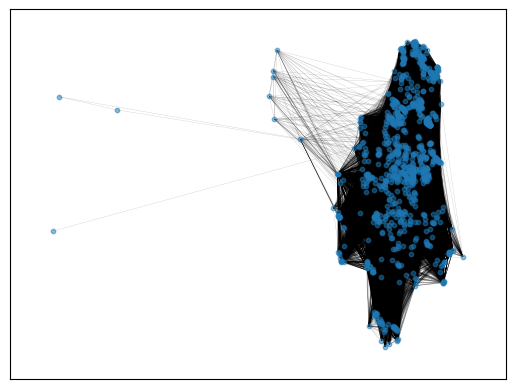

In [97]:
nx.draw_networkx(genre_graph_2, pos=spring_positions, with_labels=False, alpha=0.5, node_size=10, width=0.1)

In [106]:
df.loc[570]["tags"]

{'Free to Play': 59515,
 'MOBA': 19946,
 'Multiplayer': 15139,
 'Strategy': 14080,
 'e-sports': 11608,
 'Team-Based': 10811,
 'Competitive': 8157,
 'Action': 7832,
 'Online Co-Op': 7350,
 'PvP': 5930,
 'Difficult': 5222,
 'Co-op': 4219,
 'RTS': 4030,
 'RPG': 3707,
 'Tower Defense': 3699,
 'Fantasy': 3681,
 'Character Customization': 2862,
 'Replay Value': 2708,
 'Action RPG': 2406,
 'Simulation': 1929}

In [186]:
def tag_categories(tags: dict[str, int]):
    if not tags:
        return None
    total = sum(tags.values())
    return pd.Series({ category.lower(): votes / total for category, votes in tags.items() })

df_tags = df.apply(lambda x: tag_categories(x["tags"]), axis=1).fillna(0)

df_tags_min = df_tags.values.min()
df_tags_max = df_tags.values.max()
df_tags = (df_tags[df_tags.sum(axis=1) > 0] - df_tags_min) / (df_tags_max - df_tags_min)
# tags_to_drop = [tag for tag, weight in df_tags.sum().to_dict().items() if weight < 10 or weight > 20]
# df_tags.drop(columns=tags_to_drop, inplace=True)
df_tags.sum().sort_values()

bmx               0.005789
wrestling         0.007999
photo editing     0.021670
6dof              0.024474
jump scare        0.025315
                   ...    
free to play     26.613860
adventure        34.056278
singleplayer     39.571111
multiplayer      47.051527
action           55.725884
Length: 394, dtype: float64

In [182]:
df_tag_weights = pd.DataFrame(
    (df_tags.values * df_tags.values[:, None])
        .sum(axis=2)\
        * ~np.identity(len(df_tags), dtype=bool),
    index=df_tags.index, columns=df_tags.index
)
df_tag_weights

,570,730,578080,1623730,1063730,1172470,440,271590,1938090,550,...,1687950,299460,9420,233270,1129580,6900,247120,1388770,837470,361280
570,0.000000,0.014636,0.006828,0.000000,0.003537,0.005114,0.004295,0.000000,0.000788,0.004597,...,0.000000,0.000000,0.005628,0.000000,0.000537,0.001233,0.000000,0.000307,0.000338,0.001564
730,0.014636,0.000000,0.013285,0.000000,0.002901,0.011364,0.007698,0.003637,0.014564,0.008218,...,0.000000,0.000000,0.004065,0.001443,0.004391,0.002382,0.000407,0.004663,0.000000,0.001493
578080,0.006828,0.013285,0.000000,0.016030,0.005199,0.022800,0.004370,0.006686,0.007037,0.013024,...,0.000000,0.000000,0.001702,0.001439,0.010229,0.008797,0.000287,0.004489,0.001974,0.002929
1623730,0.000000,0.000000,0.016030,0.000000,0.007964,0.002864,0.000912,0.003603,0.000438,0.004657,...,0.002500,0.006695,0.000000,0.000000,0.008762,0.003481,0.000000,0.000000,0.003663,0.002086
1063730,0.003537,0.002901,0.005199,0.007964,0.000000,0.005028,0.000523,0.003105,0.001534,0.000000,...,0.000876,0.000000,0.000000,0.000000,0.001085,0.003572,0.000000,0.000000,0.002213,0.004074
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6900,0.001233,0.002382,0.008797,0.003481,0.003572,0.000557,0.000231,0.011188,0.003894,0.000280,...,0.001938,0.000000,0.002145,0.010439,0.002740,0.000000,0.000000,0.015751,0.018486,0.000000
247120,0.000000,0.000407,0.000287,0.000000,0.000000,0.000546,0.000316,0.000502,0.000517,0.000318,...,0.000000,0.000000,0.000188,0.000211,0.000388,0.000000,0.000000,0.000404,0.000689,0.000000
1388770,0.000307,0.004663,0.004489,0.000000,0.000000,0.006254,0.002057,0.003400,0.005490,0.003709,...,0.000000,0.000000,0.000000,0.007902,0.004159,0.015751,0.000404,0.000000,0.004131,0.001505
837470,0.000338,0.000000,0.001974,0.003663,0.002213,0.002541,0.004343,0.008794,0.000387,0.000824,...,0.001749,0.027651,0.000000,0.010724,0.006354,0.018486,0.000689,0.004131,0.000000,0.003979


In [183]:
tag_graph = nx.Graph(df_tag_weights)
tag_spring_positions = nx.spring_layout(tag_graph)

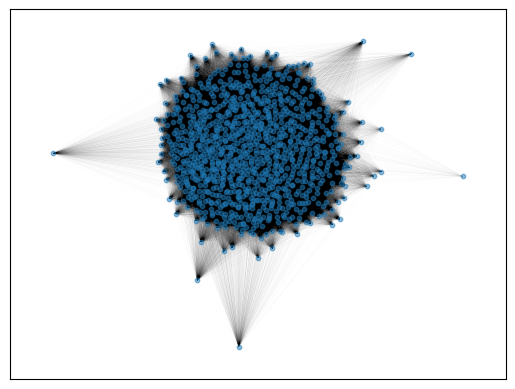

In [184]:
nx.draw_networkx_edges(tag_graph, pos=tag_spring_positions, alpha=0.05, width=0.1)
nx.draw_networkx_nodes(tag_graph, pos=tag_spring_positions, alpha=0.5, node_size=10)
plt.show()